# Loading Libraries

In [1]:
import pandas as pd
import numpy as np

import surprise
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k


# Reading Data

In [3]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_ratings_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_ratings_test.csv", index_col=0)

In [4]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (357692, 3)
Shape of Test: 	 (89479, 3)


In [5]:
# Check Head of Train
train.head()

,StockCode,CustomerID,purchased
125778,1526,2425,1
370557,1551,223,-1
440452,2043,2392,-1
428223,1756,1936,-1
285547,2043,69,-1


# Preparation of Train Dataset for Surprise Models


In [6]:
# Reader 
reader = surprise.Reader(rating_scale=(-2,2))

# Build Train Set from Custom Dataset
train_set = surprise.Dataset.load_from_df(train[['CustomerID', 'StockCode', 'purchased']], reader=reader).build_full_trainset()

# Baseline Model

In [7]:
# base_model
try:
    del(base_model)
except:
    pass

# Create Object for base_model 
base_model = surprise.SVDpp(random_state=0, n_factors=200, n_epochs=20, verbose=True)

# Fit the base_model
base_model.fit(train_set)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


# Prediction: Test Set Only

In [8]:
# Make Predictions
test_pred = predict(base_model, test, usercol='CustomerID', itemcol='StockCode')

# Show first five rows
test_pred.head()

,CustomerID,StockCode,prediction
0,1347,169,-1.173177
1,3672,1017,1.283838
2,2815,1553,-0.808983
3,1481,1092,-1.080208
4,26,1513,1.260286


In [9]:
# Check Statistics of Prediction
test_pred.prediction.describe()

count    89479.000000
mean         0.236327
std          1.008628
min         -2.000000
25%         -0.819121
50%          0.627180
75%          1.155819
max          2.000000
Name: prediction, dtype: float64

In [10]:
# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0),1,0)

# Convert Test
test['purchased'] = np.where((test['purchased']>0),1,0)

In [11]:
# Check Distribution
test_pred['prediction'].value_counts()

1    48663
0    40816
Name: prediction, dtype: int64

In [12]:
# Sort Index of both Datasets to use Accuracy Score 
test = test.sort_values(by=['CustomerID', 'StockCode'])
test_pred = test_pred.sort_values(by=['CustomerID', 'StockCode'])

# Reset indeces for both DataFrames
test = test.reset_index(drop=True)
test_pred = test_pred.reset_index(drop=True)

In [13]:
# First Reorder columns for test 
test = test[['CustomerID', 'StockCode', 'purchased']]
# Head of Test
test.head()

,CustomerID,StockCode,purchased
0,1,262,0
1,1,275,1
2,1,320,1
3,1,425,0
4,1,892,0


In [14]:
# Head of Test_pred
test_pred.head()

,CustomerID,StockCode,prediction
0,1,262,0
1,1,275,1
2,1,320,1
3,1,425,0
4,1,892,0


In [15]:
# Import Accuracy 
from sklearn.metrics import accuracy_score

# Accuracy 
accuracy_score(test.purchased, test_pred.prediction)

0.9355155958381296

# Prediction: Top N 

In [16]:
# Predict all pairs that are not in the train set
predictions = compute_ranking_predictions(base_model, train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)

In [17]:
# Check first five rows
predictions.head()

,CustomerID,StockCode,prediction
357692,2425,1931,0.125392
357693,2425,197,0.679317
357694,2425,1592,0.651663
357695,2425,43,0.642855
357696,2425,166,0.722508


In [22]:
# Filter Test for purchased items only
test = test[test['purchased']==1]

In [23]:
# Now filter out top N 
# First write a function
def filter_top_n(predictions: pd.DataFrame, n: int) -> pd.DataFrame:
    
    # Group the dataframe by 'CustomerID', and for each group, sort by 'prediction' in descending order, then take the top N rows
    top_n_per_customer = predictions.groupby('CustomerID', group_keys=False).apply(lambda group: group.sort_values('prediction', ascending=False).head(n))
    
    return top_n_per_customer

# Filter Top 10 
top_10 = filter_top_n(predictions, 10)

# Filter Top 20 
top_20 = filter_top_n(predictions, 20)


In [24]:
# Evaluate Precision at 10 
eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('precision at 10 \t:', eval_precision_10)

# Evaluate Recall at 10 
eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('recall at 10 \t:', eval_recall_10)

precision at 10 	: 0.01836398572604996
recall at 10 	: 0.013488666665623423


In [25]:
# Evaluate Precision at 20 
eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('precision at 20 \t:', eval_precision_20)

# Evaluate Recall at 20 
eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('recall at 20 \t:', eval_recall_20)

precision at 20 	: 0.016209168267911064
recall at 20 	: 0.02310357196168071


# Hyper-Parameter Tuning

In [26]:
# Define Set of Hyperparameters: 
n_factors = [5, 10, 100, 200, 1000]

# Initiate List for Metrics
factors = []
recall_k = []

# Start for loop
for factor in n_factors:
    # First Delete Model Everytime
    try:
        del(model)
    except:
        pass

    # Define Model with Parameters 
    model = surprise.SVDpp(random_state=0, n_factors=factor, n_epochs=10)

    # Fit model
    model.fit(train_set)

    # Predict all pairs that are not in the train set
    predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')

    # Filter Top 10 
    top_10 = filter_top_n(predictions, 10)

    # Evaluate Recall at 10 
    eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)

    print("recall at for", factor, "factors: \t", eval_recall_10)

    # Append Lists
    factors.append(factor)
    recall_k.append(eval_recall_10)

recall at for 5 factors: 	 0.012886385792991995
recall at for 10 factors: 	 0.013015893789292857
recall at for 100 factors: 	 0.009724499057713276
recall at for 200 factors: 	 0.010058772495395517
recall at for 1000 factors: 	 0.004381121708835912


# Tuning 2

In [29]:
# Define Set of Hyperparameters: 
n_factors = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
lr_rates = [0.001, 0.003, 0.007]
reg_terms = [0.01, 0.02, 0.03]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

# Start for loop
for factor in n_factors:
    for lr in lr_rates:
        for reg in reg_terms:
            # First Delete Model Everytime
            try:
                del(model)
            except:
                pass

            # Define Model with Parameters 
            model = surprise.SVDpp(random_state=0,
                                    n_factors=factor,
                                    n_epochs=20,
                                    lr_all=lr,
                                    reg_all=reg)

            # Fit model
            model.fit(train_set)

            # Predict all pairs that are not in the train set
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')

            # Filter Top 10 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factor, "factors: \t", eval_recall_10)
            factor_nr.append(factor)
            regulation_all.append(reg)
            lr_all.append(lr)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)

recall at for 6 factors: 	 0.012696495907878108
recall at for 6 factors: 	 0.012365354886487014
recall at for 6 factors: 	 0.011741862716755907
recall at for 6 factors: 	 0.012339026117211124
recall at for 6 factors: 	 0.011721872745723052
recall at for 6 factors: 	 0.011306532704374435
recall at for 6 factors: 	 0.00854224287788652
recall at for 6 factors: 	 0.00931434951439048
recall at for 6 factors: 	 0.010488944647113755
recall at for 7 factors: 	 0.012074476673847374
recall at for 7 factors: 	 0.011880655868647137
recall at for 7 factors: 	 0.01175090698655151
recall at for 7 factors: 	 0.012650383502402137
recall at for 7 factors: 	 0.012227251903841075
recall at for 7 factors: 	 0.011458525690374017
recall at for 7 factors: 	 0.010622641102040153
recall at for 7 factors: 	 0.010017772168309309
recall at for 7 factors: 	 0.010463522053846205
recall at for 8 factors: 	 0.011972578505401451
recall at for 8 factors: 	 0.011843131443863
recall at for 8 factors: 	 0.01251702553316839

In [32]:
dict_param2 = {
    "factor": factor_nr,
    "regulation_term": regulation_all,
    "learning_rate": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10":precision_10,
    "precision_20":precision_20
}

df_param2 = pd.DataFrame(dict_param2)
df_param2.sort_values(by="recall_10", ascending=False)

,factor,regulation_term,learning_rate,recall_10,recall_20,precision_10,precision_20
58,12,0.02,0.003,0.012864,0.023249,0.016497,0.015180
57,12,0.01,0.003,0.012783,0.023985,0.016937,0.015660
0,6,0.01,0.001,0.012696,0.023146,0.016003,0.015056
12,7,0.01,0.003,0.012650,0.023177,0.017074,0.015715
74,14,0.03,0.001,0.012633,0.024051,0.015290,0.015111
...,...,...,...,...,...,...,...
25,8,0.02,0.007,0.010198,0.019512,0.014631,0.013766
24,8,0.01,0.007,0.010043,0.019214,0.015180,0.013917
16,7,0.02,0.007,0.010018,0.020930,0.014603,0.014452
7,6,0.02,0.007,0.009314,0.018117,0.013560,0.012956


In [52]:
df_param2.describe()

,factor,regulation_term,learning_rate,recall_10,recall_20,precision_10,precision_20
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,10.500000,0.020000,0.003667,0.011683,0.022258,0.015472,0.014686
std,2.888373,0.008211,0.002508,0.000742,0.001492,0.000724,0.000580
min,6.000000,0.010000,0.001000,0.008542,0.017131,0.013231,0.012888
25%,8.000000,0.010000,0.001000,0.011460,0.021393,0.015015,0.014377
50%,10.500000,0.020000,0.003000,0.011805,0.022318,0.015482,0.014713
75%,13.000000,0.030000,0.007000,0.012103,0.023335,0.015921,0.015049
max,15.000000,0.030000,0.007000,0.012864,0.025264,0.017211,0.015811


# Best Model: Accuracy on Test Set

In [34]:
# Create Object for base_model 
best_model = surprise.SVDpp(random_state=0, n_factors=112, lr_all=0.003, reg_all=0.02, n_epochs=20, verbose=False)

# Fit the base_model
best_model.fit(train_set)

# Make Predictions
test_pred = predict(base_model, test, usercol='CustomerID', itemcol='StockCode')

# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0),1,0)

# Merge test & test_pred to get positive instances 
test_positive_pred = test.merge(test_pred, on=['CustomerID', 'StockCode'], how='left', indicator=True)

# Accuracy 
accuracy_score(test_positive_pred.purchased, test_positive_pred.prediction)

0.9242882861495242

# Visualizations best Model

In [35]:
# Import Vizualization Libraries
import seaborn as sns 
from matplotlib import pyplot as plt
import plotly.express as px

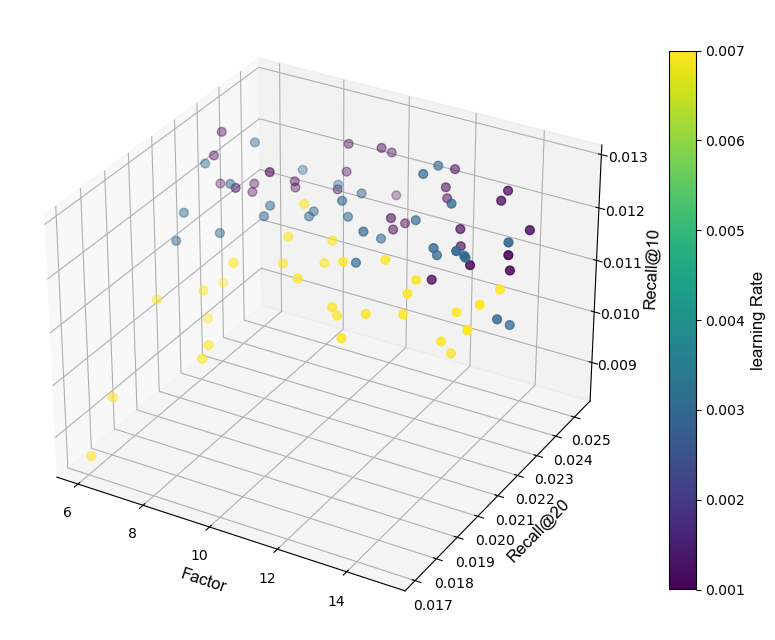

In [56]:
fig = plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_param2.factor, df_param2.recall_20, df_param2.recall_10
ax.set_xlabel('Factor', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
ax.set_ylabel('Recall@20',fontname='Arial', fontsize=12)
#ax.scatter(x,y,z, cmap='viridis', marker='o', s=40, c=df_param2.learning_rate)
scatter = ax.scatter(x,y,z, cmap='viridis', marker='o', s=40, c=df_param2.learning_rate)
#ax.set_title('Number of Factors in the latent Space for the NMF model', fontname='Arial', fontsize=15)

# Colorbar
cbar = plt.colorbar(scatter, shrink=0.7)
cbar.set_label('learning Rate', fontname='Arial', fontsize=12)
plt.show()
